# DFE and Acquisition in Dispersive Channels

We look at Decision Feedback Equalization and at how to acquire the preamble when the channel is dispersive.

<a href="https://colab.research.google.com/github/bepepa/digital_comms/blob/master/090_dispersive_acquisition_dfe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/digital_comms/blob/main/090_dispersive_acquisition_dfe.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np
from scipy import signal
from scipy.linalg import toeplitz

from typing import Tuple

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# the next cells, repeat code from earlier notebooks. It would be better to import these but
# then the notebook is no longer self-contained

In [2]:
def random_symbols(A, N):
    """generate random symbols from the constallation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [3]:
def srrc_pulse(a, fsT, N=5):
    """Construct a raised cosine pulse
    
    Inputs:
    a - roll-off factor
    fsT - number of samples per symbol period
    N - lenght of pulse in symbol periods; pulse ranges for -N \leq t/T \leq N (default: 5).

    Returns:
    Length 2*N*fsT+1 vector
    """
    # time axis with spacing 1/(fs*T)
    tt = np.linspace(-N, N, 2*N*fsT + 1)
    
    num = np.sin(np.pi*tt*(1-a)) + 4*a*tt*np.cos(np.pi*tt*(1+a))
    den = np.pi*tt*(1-(4*a*tt)**2)
    
    # deal with divide-by-zeros: at zero location, place "L'Hospital value" in numerator
    # and 1 in denominator.
    # First divide-by-zero location is t=0; by L-Hospital, the value is (1 + a*(4/pi - 1))
    ind_0 = np.where(np.abs(tt) < 1e-6)
    num[ind_0] = (1 + a*(4/np.pi - 1))
    den[ind_0] = 1
    # Second divide-by-zero location is t=+/-1/(4*a); by L-Hospital, the value is as shown below
    ind_0 = np.where(np.abs(np.abs(tt) - 1/(4*a)) < 1e-6)
    num[ind_0] = a/np.sqrt(2) * ((1+2/np.pi)*np.sin(np.pi/(4*a)) + (1-2/np.pi)*np.cos(np.pi/(4*a)))
    den[ind_0] = 1
    
    # scaling: we scale the pulse such that the convolution of two SRRC pulse yields
    # a RC pulse with amplitude 1 in the center of the pulse. This implies that
    # np.sum(hh**2) must equal 1. This replace the scaling by 1/T in the formula above.
    hh = num/den
    
    return hh / np.sqrt(np.sum(hh*hh))

In [4]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal
    
    Inputs:
    symbols - a sequence of information symbols; rate 1/T
    pulse - sampled pulse shape; rate fsT/T
    fsT - samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

In [5]:
def pop_count32(x: np.uint32) -> np.uint8:
    """count the number of 1s in 32-bit integer x using Wegner's method
    
    Inputs:
    x - a 32 bit integer

    Returns:
    an integer between 0 and 32 indicating the number of 1s in x
    """
    
    count: np.uint8 = 0
    
    while (x > 0):
        x = x & (x-1)
        count += 1
        
    return count

In [6]:
def lfsr_step(state: np.uint32, fb: np.uint32, N: int = 31) -> Tuple[np.uint8, np.uint32]:
    """Single update step of LFSR with feedback connections fb
    
    Inputs:
    * state (uint32): initial state of the feedback shift register
    * fb (uint32): bit map indicating feedback connections; the LSB corresponds to bit 0 in the LFSR
    * N (int) order if the LFSR; must be less than 32 (default: 31)
    
    Returns:
    * elem - next element of the LFSR sequence
    * state - updated state
    
    Example: Generate the first 10 elements of a LFSR sequence with fb=0b1001 and initial state=0b1111
    >>> state = 0b1111
    >>> seq = np.empty(10, dtype=np.uint8)
    >>> for n in range(10):
    >>>     seq[n], state = lfsr31_step(state, 0b1001)
    >>> seq
    
    array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)
    """
    
    # save the LSB before updating state; it will be returned
    elem: np.uint8 = state & 0b1
        
    # update state
    fb_vec: np.uint32 = state & fb
    fb_bit: np.uint8 = (pop_count32(fb_vec) & 0b1)
    
    # insert feedback bit at position N, then shift
    state = (state | fb_bit << N) >> 1
    
    return elem, state

In [7]:
def lfsr(init: np.uint32, fb: np.uint32, M: int, N: int = 31, Nc:int = 0):
    """Compute M samples of a LFSR sequence
    
    Inputs:
    init - initial state of the LFSR
    fb - feedback connection for the LFSR
    M - number of samples to generate
    N - order of the LFSR (default: 31)
    Nc - statrting sample (default 0)

    Returns:
    length-M vector of bits (stored as np.uint8)
    """
    seq = np.empty(M, dtype=np.uint8)

    state = init

    for n in range(Nc):
        _, state = lfsr_step(state, fb, N)          # discard the first Nc

    for n in range(M):  
        seq[n], state = lfsr_step(state, fb, N)     # keep the next Mc

    return seq

In [8]:
class Second_Order_Filter():
    """Class representing a second-order loop filter"""

    def __init__(self, alpha1, alpha2, state=0):
        """Initialize the gains and the state of the filter
        
        Input:
        alpha1 - linear gain
        alpha2 - integrator gain
        state - value helpd by integrator (optional, default: 0)
        """
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.state = state

    def __call__(self, d_n):
        """invoke the filter
        
        Input:
        d_n - single sample, representing error

        Returns:
        filtered sample; type is the same as the input
        """
        out = self.alpha1 * d_n + self.state
        self.state += self.alpha2 * d_n  # update state
        
        return out

    # below, we check that 0 <= alpha2 < alpha1 < 1
    @property
    def alpha1(self):
        return self._alpha1

    @alpha1.setter
    def alpha1(self, new_val):
        if new_val < 1 and new_val > 0:
            self._alpha1 = new_val
        else:
            raise ValueError("alpha1 = {:} can make PLL unstable".format(new_val))

    @property
    def alpha2(self):
        return self._alpha2

    @alpha2.setter
    def alpha2(self, new_val):
        if new_val < self._alpha1 and new_val > 0:
            self._alpha2 = new_val
        else:
            raise ValueError("alpha2 = {:} can make PLL unstable".format(new_val))

    @property
    def state(self):
        return self._state

    @state.setter
    def state(self, new_val):
        self._state = new_val

    @property
    def damping_factor(self):
        return self.alpha1 / 2 / np.sqrt(self.alpha2) 

In [9]:
class Integrator():
    """Class representing an integrator"""

    def __init__(self, state=0):
        self.state = state

    def __call__(self, x_n):
        "Compute the output from the integrator"
        out = self.state
        self.state += x_n

        return out

    @property
    def state(self):
        return self._state

    @state.setter
    def state(self, new_val):
        self._state = new_val

In [10]:
def MPE_decision_rule(Z, A):
    """Decide which symbol was most likely transmitted
    
    This function examines matched filter outputs (in vector Z) and for each element of Z selects the symbol 
    from constellation A that is closest.

    Inputs:
    Z - Vector of matched filter outputs
    A - Constellation

    Returns:
    Numpy array of the same length as Z
    """
    dec = np.empty_like(Z)

    for n in range(len(Z)):
        this_Z = Z[n]
        ind = np.argmin(np.abs(A-this_Z))
        dec[n] = A[ind]

    return dec

## DFE

The DFE adds a second filter to the equalizer. The feedback filter cancels out the ISI from past symbols.

The outputs of the two filters are combined to produce the symbol-rate signal $y[m]$, which is input to the decision device. 

The signal $y[m]$ is given by
$$
      y[m] =  \vec{v}^H \cdot \vec{r}[mM] +  \vec{v}_b^H \cdot \vec{\hat{s}}[m].
$$
where $\vec{r}[mM]$ is a length $K_f$ vector of received samples starting at $mM$ and $\vec{\hat{s}}[m]$ is a vector of $K_b$ decisions prior to $m$.

We can combine the two summands
$$
      y[m] = \left[ \vec{v}, \vec{v}_b \right]^H \cdot
      \left[ \vec{r}[mM],  \vec{\hat{s}}[m] \right] =
      \langle \vec{r}_{\text{DFE}}[m], \vec{v}_{\text{DFE}} \rangle.
$$

Adaptation of the combined weight vector works exactly like for the linear equalizer. The objective function to minimize is
$$
      J_n(\vec{v}) = \sum_{m=0}^{n} \lambda^{n-m} |e[m]|^2 =
      \sum_{m=0}^n \lambda^{n-m} |s_m - \vec{v}_{\text{DFE}}^H \cdot \vec{r}_{\text{DFE}}[mM]|^2.
$$

### How does a DFE work

The two filters complement each other: 

* the feedforward (FF) filter is intended to cope with the contributions from the current ($m$-th) symbol and future symbols.
* the feedback (FB) filter aims to cancels the interference from past symbols.

Correspondingly, The $K_f$ samples processed by the FF filter range from $r[mM]$ to $r[mM+K_f-1]$; these samples are collected in the vector $\vec{r}[mM]$. 

Note that these samples depend on symbols $s_m, s_{m+1}, \ldots, s_{m+\lceil\frac{K_f}{M}\rceil}$ but also on some prior symbols $s_{m-k}$. The number of prior symbols that impact $\vec{r}[mM]$ is given the length of the channel impulse response in symbol periods.

Recall that we can express the received vector $\vec{r}[mM]$ via the product of the channel matrix $\mathbf{C}$ and sliding vector of symbols $\vec{s}$.  The matrix $\mathbf{C}$ can be split into two parts; 
* the second part $\mathbf{C}_f$ consists of the columns that correspond to symbols $s_m, s_{m+1}, \ldots, s_{m+\lceil\frac{K_f}{M}\rceil}$
* the second part $\mathbf{C}_b$ consists of the columns that correspond to prior symbols.


#### Example

Consider a twice oversampled ($M=2$) channel with impulse response 
$c[k]=\begin{bmatrix}1.0 & 0.5j & -0.5\end{bmatrix}^T$. 
Assume further that we will employ a four-tap FF filter, i.e., the FF filter processes four received samples.

Then, we can write the received signal vector $\vec{r}[mM]$ as follows:
$$
\begin{bmatrix}
r[mM] \\ r[mM+1] \\ r[mM+2] \\ r[mM+3]
\end{bmatrix} =
\begin{bmatrix}
-0.5 & 1.0 & 0 \\
0 & 0.5j & 0 \\
0 & -0.5 & 1 \\
0 & 0 & 0.5j \\
\end{bmatrix} \cdot
\begin{bmatrix}
s_{m-1} \\ s_m \\ s_{m+1}
\end{bmatrix}
+
\begin{bmatrix}
N[mM] \\ N[mM+1] \\ N[mM+2] \\ N[mM+3]
\end{bmatrix}.
$$

We can split the channel matrix into
$$
\mathbf{C}_f = 
\begin{bmatrix}
1.0 & 0 \\
0.5j & 0 \\
-0.5 & 1 \\
0 & 0.5j \\
\end{bmatrix} 
\quad \text{and} \quad
\mathbf{C}_b = 
\begin{bmatrix}
-0.5j \\ 0 \\ 0 \\ 0
\end{bmatrix}
$$

The feedforward equalizer weights $\vec{v}_f$ can now be chosen such that
$$
    \vec{v}_f^H \cdot \mathbf{C}_f = \begin{bmatrix} 1 & 0 \end{bmatrix}
$$
so that 
$$
    \vec{v}_f^H \cdot \mathbf{C}_f \cdot \begin{bmatrix} s_m \\ s_{m+1} \end{bmatrix} = s_m.
$$
Note that the contribution of the future symbol $s_{m+1}$ has been mitigated.

We recognize the above solution as the zero-forcing (ZF) solution for the reduced channel matrix $\mathbf{C}_f$. Thus, $\vec{f}_f$ is given by
$$
    \vec{\hat{v}}_f = (\mathbf{C}_f^+)^H \cdot \vec{e}_0 = \mathbf{C}_f(\mathbf{C}_f^H \mathbf{C}_f) \cdot \vec{e}_0,
$$
where $\vec{e}_0 = \begin{bmatrix} 1 & 0 \end{bmatrix}^T$. 

Alternatively, $\vec{f}_f$ can be chosen as the MMSE solution
$$
    \vec{\hat{v}}_f = \arg \min_{\vec{v}_f} \|s_m - \vec{v}_f^H \vec{r}[mM] \|^2.
$$

We demonstrate the ZF solution.

In [11]:
## construct the channel matrix and split into two parts
c = [1, 0.5j, -0.5]
CC = np.array([
    [-0.5, 1.0,  0.0],
    [ 0.0, 0.5j, 0.0],
    [ 0.0, -0.5, 1.0],
    [ 0.0,  0.0, 0.5j]
])

CCf = CC[:, 1:]
CCb = CC[:, 0]

CCf, CCb

(array([[ 1. +0.j ,  0. +0.j ],
        [ 0. +0.5j,  0. +0.j ],
        [-0.5+0.j ,  1. +0.j ],
        [ 0. +0.j ,  0. +0.5j]]),
 array([-0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j]))

In [12]:
## Compute the weights for the FF filter
vf = np.linalg.pinv(CCf).T.conj() @ np.array([1., 0])

vf

array([ 0.76923077+0.j        ,  0.        +0.38461538j,
       -0.07692308+0.j        ,  0.        +0.15384615j])

To complete our example, we compute the weights of the feedback filter.

When the received sample vector $\vec{r}[mM]$ is passed through the FF filter with weights $\vec{v}_f$, it produces the output sample
$$
x[m] = \vec{v}_f^H \vec{r}[mM] = \vec{v}_f^H \mathbf{C} \vec{s}[m] + \vec{v}_f^H \vec{N}[mM].
$$

The product $\vec{v}_f^H \mathbf{C} \vec{s}[m]$ can be split according to the separation of $\mathbf{C}$ into $\mathbf{C}_f$ and $\mathbf{C}_b$,
$$
\vec{v}_f^H \mathbf{C} \vec{s}[m] = 
        \vec{v}_f^H \mathbf{C}_f \cdot \begin{bmatrix}s_m & s_{m+1}\end{bmatrix}^T +
        \vec{v}_f^H \mathbf{C}_b \cdot \begin{bmatrix} s_{m-1}\end{bmatrix}^T.
$$

when $\vec{v}_f$ is chosen so that $\vec{v}_f^H \mathbf{C}_f \cdot \begin{bmatrix}s_m & s_{m+1}\end{bmatrix}^T = s_m$, the FF filter's outputs
is
$$
x[m] = s_m + \vec{v}_f^H \mathbf{C}_b \cdot \begin{bmatrix} s_{m-1}\end{bmatrix}^T.
$$

The FB filter's task is to cancel the impact of prior symbols $s_{m-k}$. We recognize immediately that the weights of the feedback filter $\vec{v}_b$ must equal
$$
\vec{v}_b = -\vec{v}_f^H \mathbf{C}_b.
$$
As long as correct symbols are fed back, the interference from prior symbols will be cancelled.

In [13]:
## compute weights of FB filter
vb = -vf.conj().T @ CCb

vb

(0.3846153846153847+0j)

Let's test with some noise-free samples. The equalizer should be able to equalize them perfectly. 

In [14]:
## construct a noise-free received signal. The zeros at either end are there to give us an s_{-1} and
#  enough samples at the end. 
syms = np.array([0, 1, 1, -1, 1, -1, -1, 1j, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 0])

# filter with channel impulse response c
rr = pulse_shape(syms, c, 2)


In [15]:
# pass blocks of 4 samples through the equalizer
s_hat = np.zeros(len(syms)-2, dtype=complex)

for n in range(len(s_hat)):
    rn = rr[2*(n+1) : 2*(n+1)+4]  # <-- (n+1) accounts for the leading zero
    s_hat[n] = np.sum(rn*vf.conj()) + np.sum(syms[n]*vb.conj())

if np.allclose(s_hat, syms[1:-1]):
    print("All symbols have been successfully equalized")
else:
    print("That didn't work")

All symbols have been successfully equalized


#### MMSE Equalizer

The example above used a ZF equalizer for the FF filter. We can also design an MMSE equalizer.

To do so, we first compute the autocorrelation matrix $\mathbf{R}$ and the cross-correlation vector $\vec{p}$ and then solve the system of equations
$$
    \mathbf{R} \cdot \vec{\tilde{v}} = \vec{p},
$$
where $\vec{\tilde{v}}$ contains both the FF and the FB weights. Also, the matrix $\mathbf{R}$  and the cross-correlation vector $\vec{p}$  are computed from both received samples and prior symbols.

In [16]:
## Compute autocorrlation mtrix R and cross-correlation p
RR = np.zeros((5,5), dtype=complex)
pr = np.zeros((5,1), dtype=complex)

for n in range(len(syms)-2):
    rtn = np.concatenate( (rr[2*(n+1) : 2*(n+1)+4], [syms[n]] )).reshape(5,1)

    RR += rtn @ rtn.conj().T
    pr += rtn * np.conj(syms[n+1])

In [17]:
## compute the combined weight vector
wt = np.linalg.solve(RR, pr)

# then, split into FF and FB parts
wtf = np.squeeze(wt[:-1])
wtr = wt[-1]

# wt, wtf, wtr, vf, vb, (pr - RR @ wt).T, pr.T - RR @ np.concatenate((vf, [vb]))

Note that the MMSE solution and the ZF solution are **not** identical; they aren't even very similar. 

In fact, the matrix $\mathbf{R}$ is rank-deficient so that there are infinitely many solutions. The ZF solution is also a solution to the above system of equattions.

When noise is added to the received samples, then the matrix $\mathbf{R}$ will be full-rank and the MMSE solution is unique. In that case the ZF solution will still be different as it optimizes a different objective functions.

Let's verify that the MMSE solution also equalizes the noise-free signal perfectly.

In [18]:
# check the MMSE equalizer
s_hat = np.zeros(len(syms)-2, dtype=complex)

for n in range(len(s_hat)):
    rn = rr[2*(n+1) : 2*(n+1)+4]
    s_hat[n] = np.sum(rn*wtf.conj()) + np.sum(syms[n]*wtr.conj())

if np.allclose(s_hat, syms[1:-1]):
    print("All symbols have been successfully equalized")
else:
    print("That didn't work")

All symbols have been successfully equalized


### LMS Adaptation

The combined weight vector can be adapted as for the linear equalizer.

**LMS Update:**
$$
      \vec{v}_n = \vec{v}_{n-1} + \mu \vec{r}_{\text{DFE}}[nM] \cdot e^*[n].
$$
where the error signal $e[n]$ is 
$$
e[n] = s_n - \vec{v}_{\text{DFE}}^H \cdot \vec{r}_{\text{DFE}}[mM].
$$

The class below implements the LMS algorithm. It maintains a vector of prior symbols (either training symbols or prior decisions). The symbol are passed to the equalizer as an argument of the `update` method. This method **must** be called once every symbol period - even if no further updates to the weight vector are desired (in that case, the argument `update_weights` can be set to `False`).

In [19]:
class LMS():
    """class that implements the LMS algorithm for a linear or DFE equalizer
    
    It has the following parameters:
    - Kf: length of feedforward filter
    - Kb: length of feedback filter, set to 0 for linear equalizer
    - mu: scaling factor for gradient descent (default: 0.5)

    The LMS class provides two methods:
    - update: computes updated weights based on the difference between the eualizer output and the symbol decision
    - equalize: computes the equalizer output
    both methods are invoked once per symbol period.

    The order of invocation must be: LMS.equalize -> decision -> LMS.update

    The class maintains a vector that stores Kb prior decisions. Theis state
    vector is updated in the `update` method. Therefore, the update method MUST be called for every symbol
    even if the equalizer weights should not be updated (set `update_weights=False` when calling `update` to
    prevent that weights are recomputed).
    """

    def __init__(self, Kf:int, Kb:int, mu:float = 0.5) -> None:
        self.Kf = Kf       # length of FF filter
        self.Kb = Kb       # <-- lengh of FB filter
        self.mu = mu       # forgetting factor

        self.v = np.zeros(Kf+Kb, dtype=complex)
        self.alpha = 0.1      # small positive constant

        self.sr_sym = np.zeros(Kb, dtype=complex)  # <-- store recent decisions

    def update(self, error:complex, sym:complex, update_weights:bool = True) -> None:
        """LMS update
        
        Inputs:
        - error: difference between training/decision and equalizer output
        - sym: new training symbol or decision
        - update_weights: flag indicating if equalizer weights are recomputed (default: True)

        Returns:
        nothing

        Updates:
        - the vectors containg recent training/decision symbols as well as recent recived samples are updated
        - if `update_weights is True` then the weight vector is recomputed
        """
        if update_weights:
            # error
            e = error   # sym - self.equalize(vec_r)

            # update weight vector
            scale = self.mu / (self.alpha + vec_r.conj() @ vec_r)
            # scale = self.mu
            self.v += np.concatenate( (vec_r, self.sr_sym) ) * e.conj() * scale 

        if self.Kb > 0:
            # update state vector for a DFE
            self.sr_sym[:] = np.concatenate((self.sr_sym[1:], [sym])) # <-- store new symbol


    def equalize(self, vec_r: np.ndarray):
        """compute equalizer output"""
        
        tmp = np.concatenate( (vec_r, self.sr_sym) )  # <--- work BOTH filters
        return self.v.conj() @ tmp

### Simple Example

To begin, verify that the equalizer can equalize the samples for our simple example. This example does not involve training, the equalizer is initialized with the weights computed above. It simply checks that the equalization works correctly.

In [20]:
## let's check the simple example. 
# Set the equalizer weights as computed above and check that the outputs are right
lms = LMS(4, 1, 0.2)
lms.v = wt.reshape(1, -1) # tweak the dimensions to what the equalizer expects 

s_hat = np.zeros(len(syms)-2, dtype=complex)

for n in range(len(s_hat)):
    rn = rr[2*(n+1) : 2*(n+1)+4]
    s_hat[n] = lms.equalize(rn)
    lms.update(0, s_hat[n], update_weights=False) # <-- update prior symbols but not the weights

if np.allclose(s_hat, syms[1:-1]):
    print("All symbols have been successfully equalized")
else:
    print("That didn't work")

All symbols have been successfully equalized


### QPSK Example

To test the adaptation, we train the equalizer for $N_t$ symbol periods. After training, we measure the MSE at the equalizer output.

The channel for this example has 12 taps. That corresponds to six symbol periods with $m=2$ oversampling.

We choose the length $K_f$ of the FF filter slightly longer than the length of the channel. The length of the feedback filter is chosen to match the number of prior symbols that affect the current symbol $s_m$, i.e., $K_b=5$. 

In [21]:
## generate a QPSK signal
fsT = 2
N = 1000
A = np.exp(1j*np.pi/4*np.arange(1, 8, 2)) # QPSK alphabet

symsa = random_symbols(A, N)

## dispersive channel
ca = np.array([0.1,  -0.3j, 0, 1,  0, 0.3j, 0, 0, 0.2-0.7j, 0, 0, 0.1j])
sig = pulse_shape(symsa, ca, fsT)

SNR_db = 20
SNR = 10**(SNR_db/10)

# received signal
rra = sig + 1/(np.sqrt(2*SNR))*(np.random.randn(len(sig)) + 1j*np.random.randn(len(sig)))


In [22]:
## measure MSE for different training lengths Nt
Kf = 16    # length of FF filter
mu = 0.3
Kb = 5     # length of FB filter

Nt = np.arange(0, 200, 4)
MSE_L = np.zeros_like(Nt, dtype=float)

for n in range(len(Nt)):
    this_Nt = Nt[n]

    # instantiate RLS
    lms = LMS(Kf, Kb, mu)
    
    Nm = 0
    m = 0
    while m*fsT + Kf < len(rra) and m < len(symsa):
        vec_r = rra[m*fsT : m*fsT+Kf]

        if m <= this_Nt:
            # training
            error = symsa[m] - lms.equalize(vec_r)
            lms.update(error, symsa[m], update_weights=True)
        else:
            # equalize
            error = symsa[m] - lms.equalize(vec_r)
            MSE_L[n] += np.abs(error)**2
            lms.update(error, symsa[m], update_weights=False)
            Nm += 1

        m += 1

    MSE_L[n] = MSE_L[n]/Nm

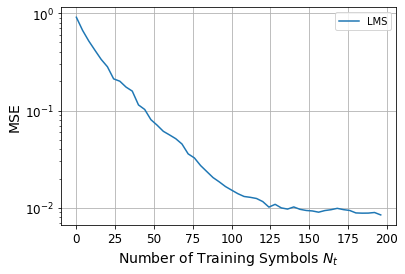

In [23]:
plt.semilogy(Nt, MSE_L, label="LMS")
plt.grid()

plt.xlabel('Number of Training Symbols $N_t$')
plt.ylabel('MSE')
plt.legend()

plt.show()

### RLS Update

Similarly, the RLS updates are given by:

$$
      \vec{v}_{\text{DFE},n} = \vec{v}_{\text{DFE},n-1} +
      \frac{e^*[n] \mathbf{R}_{n-1}^{-1} \vec{r}_{\text{DFE}}[nM]}
      {\lambda + \vec{r}_{\text{DFE}}^H[nM]\mathbf{R}_{n-1}^{-1} \vec{r}_{\text{DFE}}[nM]},
$$

and

$$
       \mathbf{R}_n^{-1} = \frac{1}{\lambda} \mathbf{R}_{n-1}^{-1} +
      \frac{(\frac{1}{\lambda}\mathbf{R}_{n-1}^{-1} \vec{r}_{\text{DFE}}[nM])
        (\frac{1}{\lambda}\mathbf{R}_{n-1}^{-1} \vec{r}_{\text{DFE}}[nM])^H}
      {1 + \vec{r}_{\text{DFE}}[nM]^H(\frac{1}{\lambda}\mathbf{R}_{n-1}^{-1} \vec{r}_{\text{DFE}}[nM])}.
$$

The class below implements the RLS algorithm. It also maintains a vector of prior symbols (either training symbols or prior decisions). The symbol are passed to the equalizer as an argument of the `update` method. This method **must** be called once every symbol period - even if no further updates to the weight vector are desired (in that case, the argument `update_weights` can be set to `False`).

In [24]:
class RLS():
    """class for carrying out the RLS algorithm
    
    This class implements the RLS algorithm for a linear or DFE equalizer.

    It has the following parameters:
    - Kf: length of feedforward filter
    - Kb: length of feedback filter, set to 0 for linear equalizer
    - fsT: oversampling factor for FF filter
    - lam: forgetting factor (0 < lamda <= 1)

    The RLS class provides two methods:
    - update: computes updated weights based on the difference between the eualizer output and the symbol decision
    - equalize: computes the equalizer output
    both methods are invoked once per symbol period.

    The order of invocation must be: RLS.equalize() -> decision() -> RLS.update()

    The class maintains a vector that stores Kb prior decisions. Theis state
    vector is updated in the `update` method. Therefore, the update method MUST be called for every symbol
    even if the equalizer weights should not be updated (set `update_weights=False` when calling `update` to
    prevent that weights are recomputed).
    """

    def __init__(self, Kf: int, Kb: int, fsT: int, lam:float = 1.) -> None:
        self.Kf = Kf       # length of FF filter
        self.Kb = Kb       # length of FB filter
        self.M = fsT       # oversampling factor for FF filter
        self.lam = lam     # forgetting factor

        self.R_inv = 1*np.eye(Kf+Kb, dtype=complex)  # inverse of auto-correlation matrix
        self.v = np.zeros(Kf+Kb, dtype=complex)      # weight vector

        ## shift register holds both recent samples and recent training symbols (or decsions)
        # the received samples are stored in the first Kf positions, the symbols are stored in the 
        # final Kb positions
        self.sr = np.zeros(Kb, dtype=complex)


    def update(self, error: complex, sym: complex, vec_rr: np.ndarray, update_weights:bool = True) -> None:
        """RLS recursion

        Inputs:
        - error - difference between training/decision and equalizer output
        - sym - the most recent training symbol or decision
        - vec_rr - vector of received samples
        - update_weights: set to False to prevent updating of equalizer weights (default: True)

        Returns:
        nothing

        Updates:
        - if `update_weights is True` all state variables are updated with the RLS algorithm 
        - state vector holding prios training/decision symbols is always updated
        
        """
        if update_weights:
            # error
            e = error # sym - self.equalize(vec_rr)

            # compute R_inv * vec_r
            tmp = np.concatenate((vec_rr, self.sr))
            vec_g = self.R_inv @ np.expand_dims(tmp, 1)

            # update R_inv
            denom = (self.lam + tmp.conj() @ vec_g)
            self.R_inv = 1/self.lam * (self.R_inv - 
                    vec_g @ vec_g.conj().T / denom)

            # update weight vector
            self.v += np.squeeze(vec_g) * e.conj()/denom

        # update the shift register that holds decisions
        if self.Kb > 0:
            self.sr[:] = np.concatenate((self.sr[1:], [sym]))


    def equalize(self, vec_rr):
        """compute equalizer output
        
        Inputs:
        vec_rr - vector of samples

        Returns:
        - equalizer output

        Updates:
        the state of the equalizer is unchanged
        """
        tmp = np.concatenate((vec_rr, self.sr))
        
        return self.v.conj() @ tmp

### QPSK Example

We pass the same QPSK samples as for the LMS algorithm through the RLS equalizer. The length of the two filters also matches that used for the LMS agorithm.

In [25]:
## Test RLS equalizer using QPSK samples
Kf = 16
Kb = 5
lam = 0.99

Nt = np.arange(0, 200, 4)
MSE = np.zeros_like(Nt, dtype=float)

for n in range(len(Nt)):
    this_Nt = Nt[n]

    # instantiate RLS
    rls = RLS(Kf, Kb, fsT, lam)
    
    Nm = 0
    m = 0
    while  m*fsT+Kf < len(rra) and m < len(symsa):
        # vec_r = rra[m*fsT : m*fsT+K]
        vec_r = rra[m*fsT : m*fsT+Kf]

        if m <= this_Nt:
            # training
            error = symsa[m] - rls.equalize(vec_r)
            rls.update(error, symsa[m], vec_r, update_weights=True)
        else:
            # equalize
            error = symsa[m] - rls.equalize(vec_r)
            MSE[n] += np.abs(error)**2
            rls.update(error, symsa[m], vec_r, update_weights=False)
            Nm += 1

        m += 1

    MSE[n] = MSE[n]/Nm

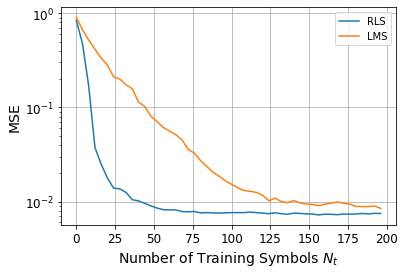

In [26]:
## compare convergence of RLS and LMS
plt.semilogy(Nt, MSE, label="RLS")
plt.semilogy(Nt, MSE_L, label="LMS")
plt.grid()

plt.xlabel('Number of Training Symbols $N_t$')
plt.ylabel('MSE')
plt.legend()

plt.show()

##  Detection in Dispersive Channels

When the channel is dispersive, the detection of the preamble is not obvious. The correlation between the received signal and the preamble sequence will have multiple peaks. The peaks are reflective of the impulse repsonse of the channel.

Recall that we modeled the received signal as 
$$
    \vec{r}[k] = \mathbf{S} \vec{c} + \vec{N}.
$$

We will use this model to detect the preamble. For that purpose:
* $\vec{r}[k]$ is the vector of received samples starting at sample index $k$; the length of this vector is equal to the length $NM$ of the preamble in sample periods.
* $\mathbf{S}$ is the Toeplitz matrix construted from the symbols of the preamble sequence. It has $NM$ rows and $LM$ columns, where $L$ is the delay spread of the channel in symbol periods.
* $\vec{c}$ is the unknown channel impulse response.

The detection problem (if $\vec{c}$ were known) is
$$
    \hat{k} = \arg \min \|\vec{r}[k] - \mathbf{S} \vec{c}\|^2.
$$

Since $\vec{c}$ is not known, we replace it with its maximum likelihood estimate:
$$
    \hat{c} = (\mathbf{S}^H\mathbf{S})^{-1}\mathbf{S}^H\vec{r}[k].
$$

Then, the detection criterion becomes
$$
\hat{k} = \arg \min \|\vec{r}[k] - \mathbf{S}(\mathbf{S}^H\mathbf{S})^{-1}\mathbf{S}^H\vec{r}[k]\|^2.
$$

I.e., the criterion compares $\vec{r}[k]$ and the projection of $\vec{r}[k]$ into the suspace spanned by the preamble sequence.

In practice, a detection occurs at time $k$ when
$$
    \rho[k] = \frac{\| \mathbf{S}(\mathbf{S}^H\mathbf{S})^{-1}\mathbf{S}^H\vec{r}[k] \|^2}
    {\|\vec{r}[k]\|^2} > \gamma
$$
where $0< \gamma \leq 1$ is a suitably chosen threshold.

**Note:** The matrix $\mathbf{S}$ contains many zeros. This can be exploited to reduce the computational complexity of teh expression above. Similarly, the matrix product $\mathbf{S}^H\mathbf{S}$ will be strongly diagonal for a good preamble sequence which can be further exploited. 

In [27]:
## preamble signal
Np = 31      # length of preamble
fb = 5      # LFSR feedback

Ap = np.array([1.0, -1.0], dtype=complex) # BPSK for preamble
pn = Ap[lfsr(1, fb, Np, 5)]

In [28]:
## construct preamble followed by signal
A = np.exp(1j*np.pi/4*np.arange(1, 8, 2)) # QPSK alphabet

N = 100
symsd = random_symbols(A, N)

## dispersive channel
fsT = 2
ca = np.array([0.1,  -0.3j, 0, 1,  0, 0.3j, 0, 0, 0.2-0.7j, 0, 0, 0.1j])
sig = pulse_shape(np.concatenate((pn,symsd)), ca, fsT)

SNR_db = 20
SNR = 10**(SNR_db/10)

delay = 31
sig = np.concatenate((np.zeros(delay, dtype=complex), sig))

# frequency offset
f_off = 0.002
sig = sig * np.exp(2j*np.pi*f_off*np.arange(len(sig)))

# received signal
rrd = sig + 1/(np.sqrt(2*SNR))*(np.random.randn(len(sig)) + 1j*np.random.randn(len(sig)))


The matrix $\mathbf{S}$ can be pre-computed from the preamble symbols.

In [29]:
## construct the matrix SS
sc = np.zeros(Np*fsT, dtype=complex)
sc[::fsT] = pn

sr = np.zeros_like(ca)
sr[0] = pn[0]

SS = toeplitz(sc, sr)

## compute the projection matrix for SS
SSp = SS @ np.linalg.pinv(SS)

Now we can compute $\rho[k]$ for sample indices $k$. Usually this would be done in a loop that terminates once the threshold $\gamma$ is breached.

In [30]:
rho = np.zeros(100)

for m in range(100):
    this_rr = np.expand_dims(rrd[m:m+62], 1)
    rp = SSp @ this_rr

    tmp = np.squeeze( (rp.conj().T @ rp) /  (this_rr.conj().T @ this_rr) )
    rho[m] = np.real(tmp)

print("The maximum of rho occurs at k = {:d} (true delay: {:d})".format(np.argmax(rho), delay))

The maximum of rho occurs at k = 31 (true delay: 31)


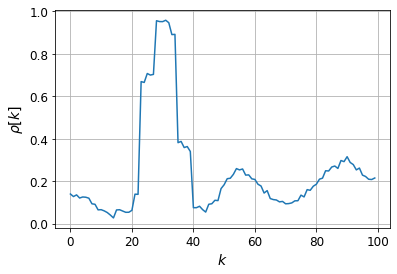

In [31]:
plt.plot(rho)
plt.grid()
plt.xlabel('$k$')
plt.ylabel(r'$\rho[k]$')
plt.show()

### Estimating the Frequency Offset

We have been able to locate the start of the preamble at sample $k=31$. 

Since the preamble sequence contains 31 symbols sampled at 2 samples per symbol, the preamble contains 62 samples.

The projection of $\vec{r}$ into the subspace spanned by $\mathbf{S}$ is  
$$
\vec{\hat{r}}[k] = \mathbf{S}(\mathbf{S}^H\mathbf{S})^{-1}\mathbf{S}^H\vec{r}[k] = \mathbf{S} \vec{\hat{c}}.
$$

Since $\vec{\hat{c}}$ is constant, it cannnot reflect the frequency offset in the received signal.

This suggest that we can estimate the frequency offset from the phase difference between $\vec{\hat{r}}$ and $\vec{r}$.

In [32]:
## project the received preamble samples onto the space spanned by S
d = np.argmax(rho) 
L = len(pn)*fsT

# projection
rrp = np.squeeze( SSp @ np.expand_dims(rrd[d:d+L], 1) )

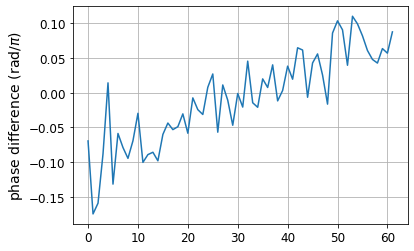

In [33]:
## compute and plot the phase difference between projection and signal
plt.plot(np.angle(rrp.conj() * rrd[d:d+L])/np.pi)
plt.grid()

plt.ylabel('phase difference (rad/$\pi$)')
plt.show()

The erratic behavior over the first few samples is due to the transient at the start of the preamble; over the first few samples the signal is still weak and the noise affects the phase strongly.

To avoid large estimation errors, the samples at the start of the preamble will be skipped. Specifically, we will skip as many samples as there are taps in the impulse response.

In [34]:
## estimate the frequency error
# since phase error is erratic at the start, we skip the first few samples
skip = len(ca)

pd = np.angle(rrp.conj() * rrd[d:d+L])
f_est = (pd[-1] - pd[skip]) / (L-skip) / (2*np.pi)

print("Estimated frequency offset: {:6.4f} (true: {:6.4f})".format(f_est, f_off))


Estimated frequency offset: 0.0018 (true: 0.0020)


## Putting it all together

We have learned about all the elements that are needed to overcome slowly time-varying channels and frequency errors. We know how to detect the preamble and how to adapt the equalizer weights and to track the time-varying phase of the channel due to frequency error.

To conclude our discussion, we will consider a comprehensive example that exercises all the tools in our toolbox. Specifically, the received signal is:
* QPSK modulated with SRRC pulse shaping
* a known preamble can be used to detect the start of the signal
* the channel is dispersive and adds AWGN
* there is a (possibly time-varying) frequency offset between transmitter and receiver

The elements of the receiver will be discussed as we process the received signal. 

In [76]:
## construct a suitable training signal followed by information symbols
# Parameters
fsT = 8     # tx oversampling; will be reduced to 2x ovesampling at rx
Np = 31      # length of preamble
fb = 5      # LFSR feedback

Ap = np.array([1.0, -1.0], dtype=complex) # BPSK for preamble
A = np.exp(1j*np.pi/4*np.arange(1, 8, 2)) # QPSK for info
Ns = 1024     # number of information symbols

hh = srrc_pulse(0.5, fsT)

# make preamble symbols and info symbols, then concatenate
pn = Ap[lfsr(1, fb, Np, 5)]
syms = random_symbols(A, Ns)

sig = pulse_shape(np.concatenate((pn, syms)), hh, fsT)

In [96]:
## channel parameters
delay_samples = 125
ds_factor = 4       # down-sample by 4

df = 0.1/(fsT*(Np-1))  # frequency offset per symbol period, phase change is 0.1*2*pi over course of preamble

# delay by pre-pending zeros
rr = np.concatenate(( np.zeros(delay_samples), sig * np.exp(2j * np.pi * df * np.arange(len(sig))) ))

# dispersive channel, length 24, spans 3 symbol periods
# the channel has two exponentially decaying segments - that's a common model for wireless multipath
# channel taps have random phase
L = 3
c = np.zeros(L*fsT, dtype=complex)
c[:len(c)//2] = np.exp(-0.25*np.arange(len(c)//2))
c[len(c)//2:] = 0.2*np.exp(-0.3*np.arange(len(c)//2))
c *= np.exp(2j*np.pi*np.random.rand(len(c)))
c = c / np.linalg.norm(c)

rr = np.convolve(c, rr)

# down-sample
rr = rr[::ds_factor]
fsT_r = fsT // ds_factor

SNR_dB = 20
SNR = 10**(SNR_dB/10)
noise_var = 1 / SNR 

# add noise 
rr = np.sqrt(ds_factor)*rr + np.sqrt(0.5 * noise_var) * (np.random.randn(len(rr)) + 1j*np.random.randn(len(rr))) 

## Receiver Processing

The first receiver task is to locate the preamble. For that purpose, we construct a symbols matrix $\mathbf{S}$ from the symbols of the preamble. 

We should not assume that we know the length of the impulse response, precisely. In fact, we don't have the exact impulse response here because the effective channel is composed of pulse shaping and multipath (as given by `c`). 

It is reasonable to assume some knowledge about the delay spread (here $L=3$ symbols). Combining that with the pulse shaping, we will assume that the channel is well described as having 12 (twice oversampled) taps.

This gives us enough information to construct the matrix $\mathbf{S}$.

In [97]:
## construct the matrix SS
Nc = Np*fsT_r
sc = np.zeros(Nc, dtype=complex)
sc[::fsT_r] = pn

Nr = 12  # assumed length of channel
sr = np.zeros(Nr, dtype=complex)
sr[0] = pn[0]

SS = toeplitz(sc, sr)

## compute the projection matrix for SS
SSp = SS @ np.linalg.pinv(SS)

Again, we cheat a little bit and perform a direct search for the location of the maximum correlation. In operation, this process would work on a window of samples that advances by one position each time.

In [98]:
rho = np.zeros(100)

for m in range(100):
    this_rr = np.expand_dims(rr[m:m+Nc], 1)
    rp = SSp @ this_rr

    tmp = np.squeeze( (rp.conj().T @ rp) /  (this_rr.conj().T @ this_rr) )
    rho[m] = np.real(tmp)

d = np.argmax(rho)

print("The maximum of rho occurs at k = {:d}".format(d))

The maximum of rho occurs at k = 33


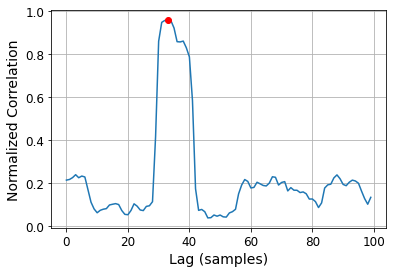

In [99]:
plt.plot(rho)
plt.plot(d, rho[d], 'ro')
plt.grid()

plt.xlabel('Lag (samples)')
plt.ylabel('Normalized Correlation')
plt.show()

### Frequency Offset Estimation

Now, that we know where the preamble is located, we can estimate the frequency error from the phase difference between the received samples and the projection of those samples into the space spanned by the coolumns of $\mathbf{S}$.

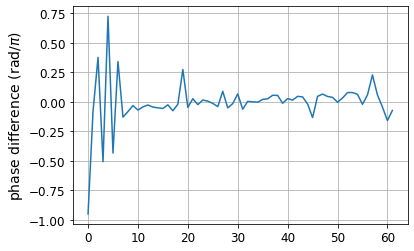

In [100]:
## project the received preamble samples onto the space spanned by S
d = np.argmax(rho) 

# projection
rrp = np.squeeze( SSp @ np.expand_dims(rr[d:d+Nc], 1) )

## compute and plot the phase difference between projection and signal
plt.plot(np.angle(rrp.conj() * rr[d:d+Nc])/np.pi)
plt.grid()

plt.ylabel('phase difference (rad/$\pi$)')
plt.show()

In [101]:
## estimate the frequency error
# since phase error is erratic at the start, we skip the first Nr samples
skip = Nr

pd = np.angle(rrp.conj() * rr[d:d+Nc])
f_est = (pd[-1] - pd[skip]) / (Nc-skip) / (2*np.pi)

print("Estimated frequency offset: {:6.4f} (true: {:6.4f})".format(f_est, ds_factor*df))

Estimated frequency offset: -0.0005 (true: 0.0017)


### Estimating the effective channel impulse response

The other quantity that we should extract from the detected preamble is the channel impulse response. We will use it to initialize the equalizer.

Recall that the maximum-likelihood estimate of the channel impulse response is 
$$
    \vec{c} = \mathbf{S}^+ \vec{r},
$$
where $\vec{r}$ holds the samples of the preamble.

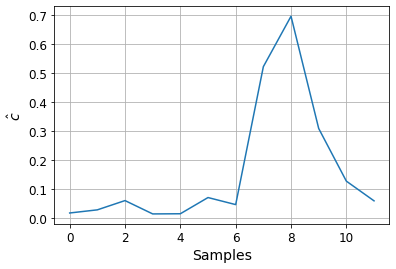

In [102]:
## Estimate the effective impulse response of the channel
c_hat = np.linalg.pinv(SS) @ rr[d:d+Nc]

# and plot it
plt.plot(np.abs(c_hat))
plt.grid()
plt.xlabel('Samples')
plt.ylabel(r'$\hat{c}$')

plt.show()

In the estimated impulse response, we can still make out one of the two "exponential peaks". It has been smoothed by the pulse shaping.

The fact that the second (smaller) peak is missing and the samll taps at the start suggest strongly that the delay estimate is not ideal. It may well be worthwhile to try another (slightly smaller) value for the delay estimate. That would shift the estimated impulse response to the left.

**Note:** these observations change from run to run because of the random nature of the impulse response.

### Initializing the Equalizer

We can now use the estimated channel impulse reponse to initialize the equalizer.

Specifically, the estimated impulse response $\vec{\hat{c}}$ is used to construct channel matrices $\mathbf{C}_f$ and $\mathbf{C}_b$.


In [103]:
## Construct the matrix Cf
# first we construct a full Toeplitz matrix and then downsample to fsT_r by deleting columns
Kf = 16   # can't go longer without running out of samples
cc = np.concatenate((c_hat, np.zeros(Kf-len(c_hat))))
cr = np.concatenate(([c_hat[0]], np.zeros(Kf-1)))

Cf = toeplitz(cc, cr)[:, 0::fsT_r]

# and then te matrix Cb
Kb = 5
Cb = np.zeros((Kf, Kb), dtype=complex)
for n in range(Kb):
    Cb[:2*(n+1), n] = c_hat[-2*(n+1):]

The matrix $\mathbf{C}_f$ is then used to determine the weights of the feedforward equalizer
$$
\vec{\hat{v}}_f = (\mathbf{C}_f^+)^H \cdot \vec{e}_0
$$

In [104]:
## Compute weights for the FF filter from matrix Cf
e0 = np.zeros(Cf.shape[1])
e0[0] = 1

vf = np.linalg.pinv(Cf).conj().T @e0

The weights of the FB filter are given by
$$
\vec{v}_b = -\vec{v}_f^H \mathbf{C}_b.
$$

In [105]:
## Compute weights for the feedback filter
vb = -vf.conj().T @ Cb

### Complete Receiver

We have initial estimates for the frequency offset and the equalizer weights.
We still have to figure out how to compbine the adaptations in the PLL and the adaptive equalizer.

A concern is that the two feedabck loops interfere with each other. The fundamental problem is that both tracking loops seek to minimimze the same objective function - the mean-squared error between the input and output to the decision device.

To avoid this we will seek to decouple the loops. The equalizer comes first, followed by the PLL closest to the decision device.

Consequently, the output of the equalizer may have a phase error that the PLL will correct.

Denote the outputput from the equaizer as $y[m]$ and the input to the decision device by $\hat{s}_m$. As the PLL corrects the phase of $y[m]$ to produce $\hat{s}_m$, we have
$$
    \hat{s}_m = y[m] \cdot e^{-j \phi[m]},
$$
where $\phi[m]$ is the current phase estimate.

The error $e[m]$ that drives the PLL is
$$
    e[m] = \bar{s}_m - \hat{s}_m.
$$

For the equalizer, the error signal should reflect the fact that a phase correction will still be applied:
$$
e_Q[m] = \bar{s}_m \cdot e^{j \phi[m]} - y[m] = \bar{s}_m \cdot e^{j \phi[m]} - \hat{s}_m \cdot e^{j \phi[m]} = e[m] \cdot e^{j \phi[m]}.
$$
The equalizer updates should be driven by the error signal $e[m]$ rotated by the current phase estimate.

In [106]:
## initialize the PLL
alpha1 = 0.1    # gains for PLL
alpha2 = 0.004

HP = Second_Order_Filter(alpha1, alpha2)
SP = Integrator()
SP.state = 0                # the equalizer does amplitude and phase correction, set initial phase to 0
HP.state = 2*np.pi*f_est    # and frequency estimate

## and the DFE
eq = LMS(Kf, Kb, 0.5)
eq.v = np.concatenate((vf, vb))  # set equalizer weights reshape(1, -1)
eq.sr_sym = pn[-Kb:]             # set last Kb training symbols

start = d + Nc  # index of first payload symbol


Now, we can demodulate the payload. The order of steps is:

1. equalize
2. correct phase
3. decision
4. update PLL with phase error
5. update equalizer (with phase rotated error)

In [107]:
## demodulate the payload with the help of a PLL and LMS equalizer

s_hat = np.zeros_like(syms)
ss_vec = np.zeros_like(syms)
yy_vec = np.zeros_like(syms)

for m in range(Ns):
    # get vector of received samples
    vec_rr = rr[start:start+Kf]

    # apply equalizer
    y = eq.equalize(vec_rr)
    yy_vec[m] = y

    # phase correction
    phi = SP.state
    ss = y * np.exp(-1j*phi)
    ss_vec[m] = ss

    # decision
    s_hat[m] = MPE_decision_rule([ss], A)

    # decision feedback
    error = s_hat[m] - ss

    # update PLL
    dphi = np.angle(ss / s_hat[m])
    tmp = HP(dphi)
    SP(tmp)

    # update EQ - rotate error by phi
    eq.update(error * np.exp(1j*phi), s_hat[n])


    start += fsT_r

print("Number of errors in {:d} symbols: {:d}".format(Ns, np.sum(syms != s_hat)))


Number of errors in 1024 symbols: 0


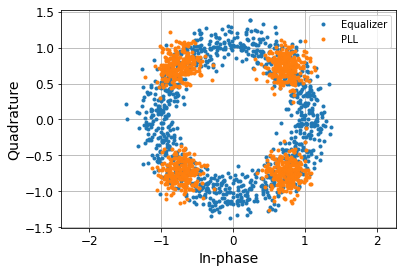

In [108]:
## plot the constellation
plt.plot(yy_vec.real, yy_vec.imag, '.', label="Equalizer")
plt.plot(ss_vec.real, ss_vec.imag, '.', label="PLL")
plt.grid()
plt.axis('equal')
plt.legend()
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.show()

## Summary

We have shown a complete receiver that is able to overcome channel dispersion and frequency error. This includes detection of the signal by means of a known preamble signal and adaptive demodulation of the payload.

Also, we have see how the results from the initial acqiuisition can be used to initialize both the PLL and the equalizer.